## Make reports with Hantek 4032L USB-based 32-channel logic analyzer and sigrok software.

>Developed by [@edyatl](https://github.com/edyatl) March 2024 <edyatl@yandex.ru>

In [1]:
# Load Jupyter extension for auto correction coding style based on Black Lib
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Install a pip package in the current Jupyter kernel
# import sys

# !{sys.executable} -m pip install -U rpi.gpio
# !{sys.executable} -m pip uninstall -y notebook


<IPython.core.display.Javascript object>

## Introduction

In modern electronics and digital systems design, analyzing signals is a critical aspect of debugging and troubleshooting. Whether it's examining communication between microcontrollers, monitoring sensor outputs, or verifying the functionality of digital circuits, having the ability to capture, process, and analyze signals accurately is essential for engineers and developers.

The **analyzer-reporter** program addresses this need by providing a comprehensive solution for capturing logic signals, processing them, and generating reports for analysis. This notebook serves as a guide to understand the functionalities and usage of the analyzer-reporter program.

In this notebook, we will explore the functionalities of the analyzer-reporter program, demonstrate its usage through practical examples, and showcase its capabilities in analyzing digital signals effectively.

## Check two datasets in CSV on storage

>**Note:** The analyzer-reporter program offers flexibility in data acquisition by supporting two modes: retrieving data directly from a connected analyzer or loading data from a CSV file. Depending on the selected mode, the program can either make requests to the analyzer using the `sigrok-cli` program (requiring the sigrok package to be installed on the system) or load data from a specified .csv file.

In the upcoming examples, we will demonstrate the functionality of the analyzer-reporter program using data from two different files: *"../data4.csv"* and *"../data1.csv"*. Before proceeding, let's ensure the presence of these files by executing a shell command to display the first few lines of each file.

In [3]:
# Execute a shell command
!head ../data4.csv && head ../data1.csv

AS3-2,AS3-1,AS4-2,AS4-1
1,0,0,1
1,0,0,1
1,0,0,1
1,0,0,1
1,0,0,1
1,0,0,1
1,0,0,1
1,0,0,1
1,0,0,1
logic1,logic2,logic3,logic4,logic5,logic6
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0


<IPython.core.display.Javascript object>

## Class Configuration - Setting up the Program

The `Configuration` class module serves as the backbone of the analyzer-reporter program, housing essential variables that dictate its operational modes. These variables determine crucial aspects such as data acquisition methods, interface settings, signal processing parameters, and more.

### Manual Configuration or Automated Setup

Users have the option to configure the program manually by editing the `Configuration` class module directly or utilizing the convenient `CONFIGURE.sh` bash script. The script provides a step-by-step interface for modifying key variables, allowing users to set new values or retain default configurations effortlessly.

>**Note:** It's worth noting that while the script focuses on modifying main variables, the `Configuration` class module encompasses additional variables with default values. Users retain the flexibility to adjust these variables manually as needed for fine-tuning the program's behavior to their specific requirements.

In [4]:
# Uncomment and run the shell command below if you need the full contents of the module file.
# !cat config.py

<IPython.core.display.Javascript object>

In [5]:
import os
from datetime import datetime


class Configuration:
    """Configuration class"""

    # Debugging
    DEBUG = True

    # Plotting
    SHOW_GRID = True  # Show grid in plots
    TIME_UNITS = "ms"
    PLOT_WIDTH = "all"  # "all" "rising" "falling" None

    # Define GPIO pin numbers
    LED_PIN = 23
    BUTTON_PIN = 24

    # Interface
    BLINK_TIME = 0.25
    BUTTON_TIMEOUT = 15  # 15

    # Signal Processing
    FILTER_WSIZE = 15

    # Data Capture
    REAL_CAPTURE = False  # Real capturing is not available yet
    EXAMPLE_DATA = "data4.csv"  # Sample data instead of real capturing
    EXAMPLE_DATA_DIR = "../"
    CAPTURE_COMMAND = [
        "sigrok-cli",
        "--driver",
        "hantek-4032l",
        "--channels",
        "A0=AS4_2,A1=AS4_4,A2=AS3_2,A3=AS3_4,A4=AS6_2,A5=AS6_4,A6=AS7_2,A7=AS7_4,A8=AS1_4,A9=AS2_4",
        "--output-format",
        "csv:label=channel:header=false",
        "--config",
        "samplerate=1000",
        "--samples",
        "4096",
    ]
    MAX_CAPTURE_ATTEMPTS = 3
    RETRY_DELAY_SECONDS = 2

    # Reporting
    ATTEMPT_POINT = (470, 767)  # XY point of attempt number in report canvas
    DATE_POINT = (470, 752)  # XY point of date in report canvas
    CURRENT_DATE = datetime.now().strftime("%Y-%m-%d")

    # USB Storage
    USB_DEVICE = "sdb"  # Change it to sda on Raspberry Pi
    USB_PART = USB_DEVICE + "1"
    USB_DRIVE = os.path.join("/dev", USB_PART)
    WRITE_TRESHOLD = 100000  # 100KB

    # Paths and Files
    DATA_DIR_NAME = "data"
    IDX_STR = "{IDX}"
    REPORT_NAME = f"{CURRENT_DATE}-{IDX_STR}.pdf"
    TEMPLATE_FILE = os.path.join(os.path.abspath("../"), "template2.pdf")
    LOG_FILE = os.path.join(
        os.path.dirname(os.path.abspath("")), "analyzer_reporter.log"
    )

    # Colors Definition
    COLORS = [
        "#1f77b4",  #  1 blue
        "#ff7f0e",  #  2 orange
        "#2ca02c",  #  3 green
        "#d62728",  #  4 red
        "#9467bd",  #  5 purple
        "#8c564b",  #  6 brown
        "#e377c2",  #  7 pink
        "#bc8dd8",  #  8 violet
        "#bcbd22",  #  9 yellow
        "#17becf",  # 10 cyan
        "#7f7f7f",  # 11 gray
    ]
    CLR_NAMES = [
        "blue",
        "orange",
        "green",
        "red",
        "purple",
        "brown",
        "pink",
        "violet",
        "yellow",
        "cyan",
        "gray",
    ]
    CLR_DICT = dict(zip(CLR_NAMES, COLORS))

<IPython.core.display.Javascript object>

Here's a list of all properties in the `Configuration` class along with their descriptions:

1. **DEBUG**: 
   - Description: Controls the debugging mode of the program. When set to `True`, debug messages will be logged and some information will be displayed in standard output.
   
2. **SHOW_GRID**: 
   - Description: Determines whether grid lines should be shown in plots generated by the program.

3. **PLOT_WIDTH**: 
   - Description: Determines what signals should be displayed with pulse width drawing on the plot. The possible values are "all" (display all signals with width drawing), "rising" (display only for rising signals), "falling" (display only for falling signals), or None (no width drawing).

4. **TIME_UNITS**: 
   - Description: Specifies the time units used for plotting, such as milliseconds (`ms`).

5. **LED_PIN**: 
   - Description: Defines the GPIO pin number used for controlling the LED.

6. **BUTTON_PIN**: 
   - Description: Defines the GPIO pin number used for the button interface.

7. **BLINK_TIME**: 
   - Description: Specifies the duration for LED blinking, typically used for indicating certain program states.

8. **BUTTON_TIMEOUT**: 
   - Description: Determines the timeout duration for waiting for button presses.

9. **FILTER_WSIZE**: 
   - Description: Defines the window size used for signal filtering during signal processing.

10. **REAL_CAPTURE**: 
   - Description: Controls whether real-time capturing is enabled. If set to `True`, the program will attempt to capture signals using the specified capture command from `sigrok-cli`.

11. **EXAMPLE_DATA**: 
    - Description: Specifies the filename of the example data to be used if real capturing is not available.

12. **EXAMPLE_DATA_DIR**: 
    - Description: Specifies the directory path where example data files are located.

13. **CAPTURE_COMMAND**: 
    - Description: Defines the `sigrok-cli` command used for capturing signals if real capturing is enabled.

14. **MAX_CAPTURE_ATTEMPTS**: 
    - Description: Specifies the maximum number of attempts to capture signals in case of failure.

15. **RETRY_DELAY_SECONDS**: 
    - Description: Specifies the delay duration (in seconds) between capture attempts.

16. **ATTEMPT_POINT**: 
    - Description: Specifies the XY coordinates for the attempt number in the generated report canvas.

17. **DATE_POINT**: 
    - Description: Specifies the XY coordinates for the date in the generated report canvas.

18. **CURRENT_DATE**: 
    - Description: Stores the current date in the format `%Y-%m-%d`.

19. **USB_DEVICE**: 
    - Description: Defines the USB device identifier.

20. **USB_PART**: 
    - Description: Defines the USB device partition identifier.

21. **USB_DRIVE**: 
    - Description: Specifies the path to the USB drive.

22. **WRITE_TRESHOLD**: 
    - Description: Specifies the threshold for free space on the USB drive, below which the program will not write reports.

23. **DATA_DIR_NAME**: 
    - Description: Specifies the name of the directory where reports files are stored.

24. **IDX_STR**: 
    - Description: Placeholder string used for constructing report filenames with index numbers.

25. **REPORT_NAME**: 
    - Description: Specifies the format for report filenames, including the placeholder for index numbers.

26. **TEMPLATE_FILE**: 
    - Description: Specifies the filepath for the template used in generating reports.

27. **LOG_FILE**: 
    - Description: Specifies the filepath for the log file used for logging program events.

28. **COLORS**: 
    - Description: Defines a list of colors used for plotting signals and pulses.

29. **CLR_NAMES**: 
    - Description: Defines a list of color names corresponding to the `COLORS` list.

30. **CLR_DICT**: 
    - Description: Maps color names to their corresponding hexadecimal color codes for ease of use in plotting.

### Usage Examples

#### Accessing Configuration Parameters

In [6]:
import pandas as pd
from config import Configuration as cfg

csv_data = os.path.join(os.path.abspath(cfg.EXAMPLE_DATA_DIR), cfg.EXAMPLE_DATA)

df = pd.read_csv(csv_data)
df

,AS3-2,AS3-1,AS4-2,AS4-1
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1
...,...,...,...,...
10235,0,1,0,1
10236,0,1,0,1
10237,0,1,0,1
10238,0,1,0,1


<IPython.core.display.Javascript object>

#### Changing Configuration Parameters

In [7]:
cfg.EXAMPLE_DATA = "data1.csv"

csv_data = os.path.join(os.path.abspath(cfg.EXAMPLE_DATA_DIR), cfg.EXAMPLE_DATA)

df = pd.read_csv(csv_data)
df

,logic1,logic2,logic3,logic4,logic5,logic6
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
10235,0,0,0,0,0,0
10236,0,0,0,0,0,0
10237,0,0,0,0,0,0
10238,0,0,0,0,0,0


<IPython.core.display.Javascript object>

>**Notes:**
>- The `Configuration` class simplifies the management of application settings by providing a single location for configuration parameters.
>- Modify the configuration parameters as needed to customize the behavior of the application according to your requirements.

## Class AnalyzerController - Capturing data

The `AnalyzerController` class is a part of the analyzer_reporter project and is designed to control the Hantek 4032L logic analyzer. It provides functionality to capture signals from the logic analyzer, either in real-time or from sample data stored in a file. This class encapsulates the logic for capturing signals, handling errors, and converting the captured data into a pandas DataFrame for further analysis.

In [8]:
# Uncomment and run the shell command below if you need the full contents of the module file.
# !cat analyzer_controller.py

<IPython.core.display.Javascript object>

In [9]:
import os
import io
import time
import subprocess
import pandas as pd

from config import Configuration as cfg
from logger import get_cls_logger


class AnalyzerController:
    """Class to control Hantek 4032L logic analyzer"""

    logger = get_cls_logger(__qualname__)

    def __init__(self):
        self.real_capture = cfg.REAL_CAPTURE
        self.data_path = os.path.join(
            os.path.abspath(cfg.EXAMPLE_DATA_DIR), cfg.EXAMPLE_DATA
        )

        self.logger.debug("Initialized %s", self.__class__.__name__)

    def capture_signals(self) -> pd.DataFrame:
        """
        Capture signals from Hantek 4032L logic analyzer.
        If real capturing is not available yet, loads sample data from file.
        """
        if self.real_capture:
            # Retry capturing for a few attempts if an error occurs
            for attempt in range(1, cfg.MAX_CAPTURE_ATTEMPTS + 1):
                try:
                    # Perform real capturing using sigrok-cli and store the output in a buffer
                    command = cfg.CAPTURE_COMMAND
                    with subprocess.Popen(command, stdout=subprocess.PIPE) as process:
                        output, _ = process.communicate()
                        output_str = output.decode("utf-8")

                    # Convert the output to a pandas DataFrame
                    df = pd.read_csv(io.StringIO(output_str))
                    self.logger.debug(
                        "Buffer after sigrok-cli loaded to DataFrame: %s rows",
                        df.shape[0],
                    )
                    return df

                except subprocess.CalledProcessError as e:
                    self.logger.error(
                        "Error occurred while capturing signals: %s", str(e)
                    )
                    self.logger.debug(
                        "Attempting to capture signals again (Attempt %d/%d)",
                        attempt,
                        cfg.MAX_CAPTURE_ATTEMPTS,
                    )
                    time.sleep(cfg.RETRY_DELAY_SECONDS)

                except pd.errors.ParserError as e:
                    self.logger.error("Error occurred while parsing output: %s", str(e))
                    self.logger.debug(
                        "Attempting to capture signals again (Attempt %d/%d)",
                        attempt,
                        cfg.MAX_CAPTURE_ATTEMPTS,
                    )
                    time.sleep(cfg.RETRY_DELAY_SECONDS)

            self.logger.error(
                "Failed to capture signals after %d attempts", cfg.MAX_CAPTURE_ATTEMPTS
            )
            return pd.DataFrame()
        # Try to load sample data from file and if error return empty DataFrame
        try:
            df = pd.read_csv(self.data_path)
            self.logger.debug("Data loaded from file: %s", self.data_path)
            return df
        except (pd.errors.ParserError, FileNotFoundError) as e:
            self.logger.error("Error occurred while loading sample data: %s", str(e))
            return pd.DataFrame()

<IPython.core.display.Javascript object>

### Usage Examples

#### Instantiating the AnalyzerController


In [10]:
from analyzer_controller import AnalyzerController

# Instantiate the AnalyzerController
analyzer = AnalyzerController()


<IPython.core.display.Javascript object>

#### Capturing Signals


In [11]:
# Set the flag to use real capturing in config.py module instead below approach
analyzer.real_capture = True

# Try capture signals from the logic analyzer
try:
    df = analyzer.capture_signals()
except FileNotFoundError as e:
    print(f"Error occurred while capturing signals: {e}")
    df = pd.DataFrame()

# Check if the DataFrame is empty (indicating a failed capture attempt)
if not df.empty:
    # Successfully captured signals, perform further analysis
    print("Signals captured successfully:")
    print(df.head())
else:
    # Failed to capture signals, handle error
    print("Failed to capture signals. Check logs for details.")

Error occurred while capturing signals: [Errno 2] No such file or directory: 'sigrok-cli'
Failed to capture signals. Check logs for details.


<IPython.core.display.Javascript object>

1. **Handling `sigrok-cli` Installation Issues:**
   - If `sigrok` is not installed or not properly added to the system path, an error message stating "No such file or directory: 'sigrok-cli'" will occur.
   - The program currently handles exceptions for `subprocess.CalledProcessError` and `pd.errors.ParserError` but does not handle `FileNotFoundError`, which may arise due to the absence of the `sigrok-cli` executable.

2. **Default `sigrok-cli` Command:**
   - The default command for `sigrok-cli` is provided as follows:
     ```bash
     sigrok-cli --driver hantek-4032l \
                --channels A0=AS4_2,A1=AS4_4,A2=AS3_2,A3=AS3_4,A4=AS6_2,A5=AS6_4,A6=AS7_2,A7=AS7_4,A8=AS1_4,A9=AS2_4 \
                --output-format csv:label=channel:header=false \
                --config samplerate=1000 \
                --samples 4096
     ```
   - This command specifies various parameters such as the driver, channels, output format, sample rate, and number of samples.

3. **Best Practice:**
   - Before setting `REAL_CAPTURE` to `True` in the configuration file, it is recommended to try running the default `sigrok-cli` command in the shell to ensure that `sigrok` is properly installed and configured.
   - Users can modify the default `sigrok-cli` command in the `config.py` file according to their requirements or if a different `sigrok` command is preferred.

By trying the default `sigrok-cli` command in the shell beforehand, users can avoid potential errors related to `sigrok` installation and configuration, ensuring smooth operation of the program.

#### Using Sample Data


In [12]:
# Set the flag to use sample data instead of real capturing
analyzer.real_capture = False

# Capture signals from the sample data file
df = analyzer.capture_signals()

# Check if the DataFrame is empty (indicating an error while loading sample data)
if not df.empty:
    # Successfully loaded sample data, perform further analysis
    print("Sample data loaded successfully:")
    print(df.head())
else:
    # Failed to load sample data, handle error
    print("Failed to load sample data. Check logs for details.")

Sample data loaded successfully:
   logic1  logic2  logic3  logic4  logic5  logic6
0       0       0       0       0       0       0
1       0       0       0       0       0       0
2       0       0       0       0       0       0
3       0       0       0       0       0       0
4       0       0       0       0       0       0


<IPython.core.display.Javascript object>

In [13]:
# Change sample data file
cfg.REAL_CAPTURE = False
cfg.EXAMPLE_DATA = "data4.csv"

# Reinstantiate the AnalyzerController
analyzer = AnalyzerController()

# Capture signals from the sample data file
df = analyzer.capture_signals()

# Check if the DataFrame is empty (indicating an error while loading sample data)
if not df.empty:
    # Successfully loaded sample data, perform further analysis
    print("Sample data loaded successfully:")
    print(df.head())
else:
    # Failed to load sample data, handle error
    print("Failed to load sample data. Check logs for details.")

Sample data loaded successfully:
   AS3-2  AS3-1  AS4-2  AS4-1
0      1      0      0      1
1      1      0      0      1
2      1      0      0      1
3      1      0      0      1
4      1      0      0      1


<IPython.core.display.Javascript object>

>**Notes:**
>- Ensure that the `config.py` file is properly configured with the necessary parameters for capturing signals.
>- Check the logs for detailed information in case of errors or failures during signal capturing.

## Class SignalProcessor - Filtering noise and calculate metrics in signals series

The `SignalProcessor` class is a part of the analyzer_reporter project and is designed to process signals obtained from various sources. It provides functionality to filter noise, find pulse pivots, and calculate pulse count and pulse width for each signal. This class encapsulates the signal processing logic, leveraging tools from the pandas, numpy, and scipy libraries.

In [14]:
# Uncomment and run the shell command below if you need the full contents of the module file.
# !cat signal_processor.py

<IPython.core.display.Javascript object>

In [15]:
import pandas as pd
import numpy as np
from scipy import signal

from config import Configuration as cfg
from logger import get_cls_logger


class SignalProcessor:
    """Class to process signals"""

    logger = get_cls_logger(__qualname__)

    def __init__(self, signals_df: pd.DataFrame):
        self.signals_df = signals_df

        # Filter noise for each signal
        self.filtered_signals_df = self._filter_noise()

        # Find pulse pivots for each signal
        self.pulse_pivots_df = self._find_pulse_pivots()

        # Calculate pulse count and pulse width for each signal
        self.pulse_count, self.pulse_points_width = self._calculate_pulse_metrics()

        self.rising_signals = self._determine_rising_signals()

        self.logger.debug("Initialized %s", self.__class__.__name__)

    def _filter_noise(self) -> pd.DataFrame:
        """Filter noise for each signal."""
        return self.signals_df.apply(lambda col: signal.medfilt(col, cfg.FILTER_WSIZE))

    def _find_pulse_pivots(self) -> pd.DataFrame:
        """Find pulse pivots for each signal."""
        return self.filtered_signals_df.apply(np.diff)

    def _calculate_pulse_metrics(self) -> tuple:
        """Calculate pulse count and pulse width for each signal."""
        pulse_count = {}
        pulse_points_width = {}
        for col in self.pulse_pivots_df.columns:
            pulse_points_width[col] = self._signal_pulse_points_width(
                self.pulse_pivots_df[col]
            )
            pulse_count[col] = len(pulse_points_width[col])

        return pulse_count, pulse_points_width

    def _determine_rising_signals(self) -> dict:
        """Determine rising signals."""
        return {
            col: self._is_rising_signal(self.pulse_pivots_df[col])
            for col in self.pulse_pivots_df.columns
        }

    @staticmethod
    def _is_start_from_pulse(sig_pivots: pd.Series) -> bool:
        """Function to check if signal is start from pulse."""
        all_indices = np.atleast_1d(sig_pivots).nonzero()[0]
        differences = np.diff(all_indices)
        return np.sum(differences[::2]) < np.sum(differences[1::2])

    @staticmethod
    def _signal_pulse_points_width(sig_pivots: pd.Series) -> list:
        """Function to calculate pulses points and width."""
        all_indices = np.atleast_1d(sig_pivots).nonzero()[0]
        differences = np.diff(all_indices)
        if SignalProcessor._is_start_from_pulse(sig_pivots):
            pulses_points, pulses_width = all_indices[:], differences[::2]
        else:
            pulses_points, pulses_width = all_indices[1:], differences[1::2]

        # Ensure even number of pulse points
        if len(pulses_points) % 2 != 0:
            pulses_points = pulses_points[:-1]

        pulses_points = np.split(pulses_points, len(pulses_points) // 2)

        return [
            np.append(_point, _width)
            for _point, _width in zip(pulses_points, pulses_width)
        ]

    @staticmethod
    def _is_rising_signal(_signal: pd.Series) -> bool:
        """Function to check if signal is rising."""
        all_indices = np.atleast_1d(_signal).nonzero()[0]
        rising_edges = np.where(np.atleast_1d(_signal) == 1)[0]
        first_edge_is_rising = all_indices[0] == rising_edges[0]

        if SignalProcessor._is_start_from_pulse(_signal):
            return first_edge_is_rising
        return not first_edge_is_rising

    @property
    def pulse_points(self) -> dict:
        """Property to access pulse points (X1, X2)."""
        return {
            k: list(map(lambda x: x[:2], v)) for k, v in self.pulse_points_width.items()
        }

    @property
    def pulse_width(self) -> dict:
        """Property to access pulse width."""
        return {
            k: list(map(lambda x: x[2], v)) for k, v in self.pulse_points_width.items()
        }

<IPython.core.display.Javascript object>

### Usage Examples

#### Instantiating the SignalProcessor


In [16]:
# from signal_processor import SignalProcessor

# Assuming df is a pandas DataFrame containing the signals data
# Instantiate the SignalProcessor
processor = SignalProcessor(df)


<IPython.core.display.Javascript object>

#### Filtering Noise

In [17]:
# Filter noise for each signal
filtered_df = processor.filtered_signals_df

<IPython.core.display.Javascript object>

#### Signals plot before filterig noise

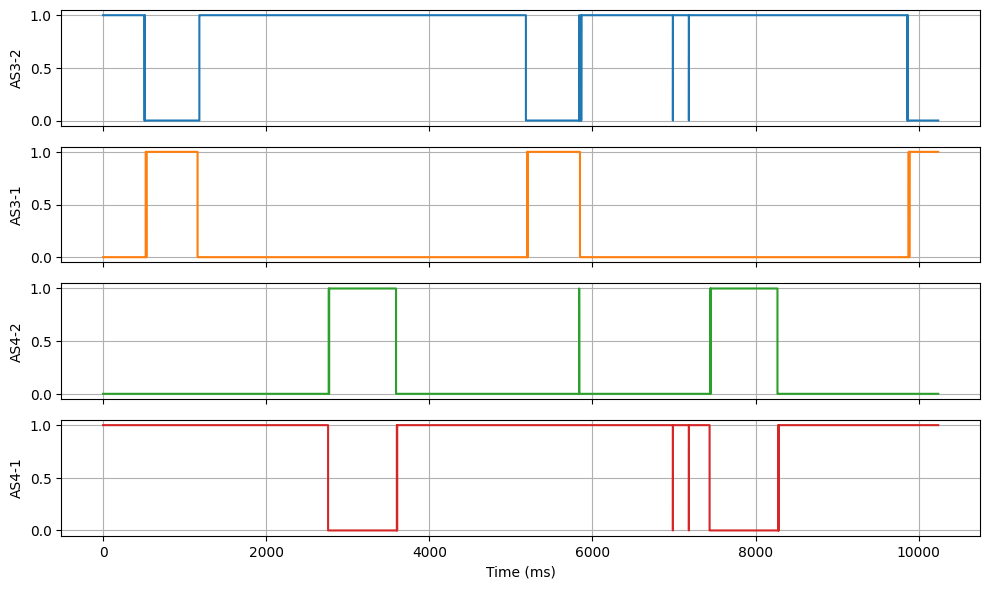

<IPython.core.display.Javascript object>

In [18]:
import matplotlib.pyplot as plt


def plot_df(df: pd.DataFrame) -> None:
    t = df.index

    fig, axes = plt.subplots(df.shape[1], 1, sharex="col", figsize=(10, 6))

    for i, col in enumerate(df.columns):
        axes[i].step(t, df[col], cfg.COLORS[i])
        axes[i].set_ylabel(col)

    for ax in axes:
        ax.grid(cfg.SHOW_GRID)  # Add grid to each subplot

    plt.xlabel("Time (ms)")
    plt.tight_layout()  # Adjust subplot layout to prevent overlapping
    plt.show()


plot_df(df)

#### Signals plot after filterig noise

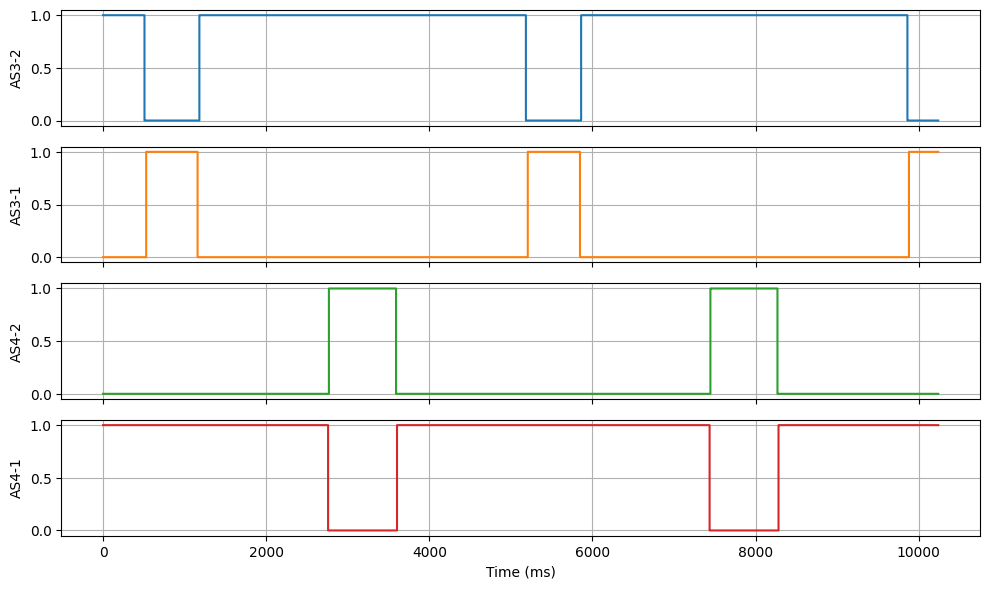

<IPython.core.display.Javascript object>

In [19]:
plot_df(filtered_df)

### Mesuring of signal pulse width

#### Finding Pulse Pivots

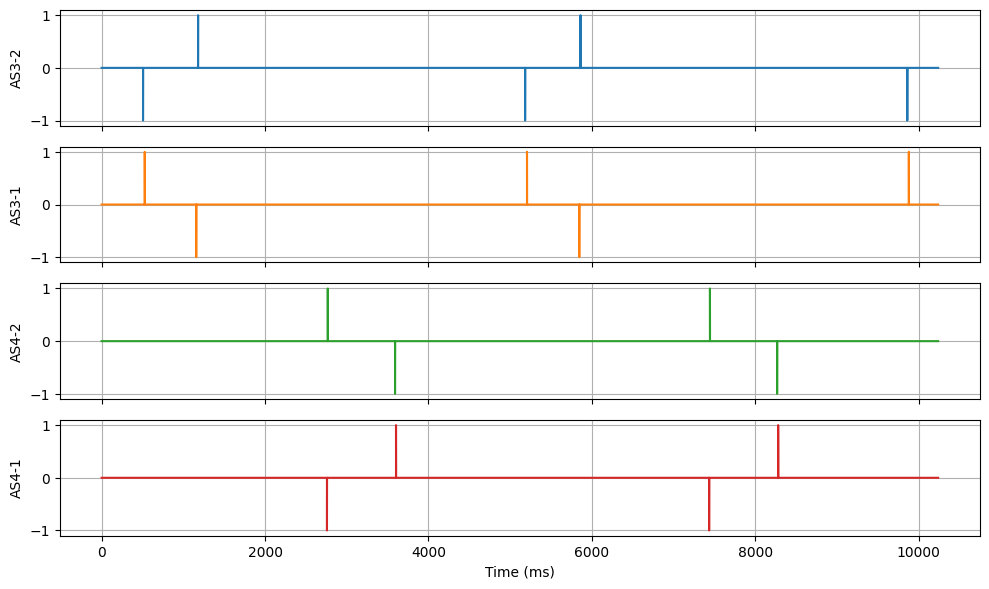

<IPython.core.display.Javascript object>

In [20]:
# Find pulse pivots for each signal
pulse_pivots_df = processor.pulse_pivots_df

plot_df(pulse_pivots_df)

>**Notes:**
>   - In the `pulse_pivots_df` DataFrame generated by the `SignalProcessor` class, rising edges are represented by the value `1`, while falling edges are represented by the value `-1`.
>   - This characteristic is clearly visible on plots above, where upward spikes correspond to rising edges and downward spikes correspond to falling edges.

#### Calculating Pulse Metrics

In [21]:
# Access properties to get pulse points and pulse width
print("Pulse Count:")
print(processor.pulse_count)

print("\nPulse Points:")
print(processor.pulse_points)

print("\nPulse Width:")
print(processor.pulse_width)

print("\nPulse Points and Width:")
print(processor.pulse_points_width)

print("\nRising signals:")
print(processor.rising_signals)

Pulse Count:
{'AS3-2': 2, 'AS3-1': 2, 'AS4-2': 2, 'AS4-1': 2}

Pulse Points:
{'AS3-2': [array([ 508, 1181]), array([5184, 5861])], 'AS3-1': [array([ 529, 1159]), array([5207, 5847])], 'AS4-2': [array([2769, 3592]), array([7446, 8268])], 'AS4-1': [array([2759, 3604]), array([7436, 8281])]}

Pulse Width:
{'AS3-2': [673, 677], 'AS3-1': [630, 640], 'AS4-2': [823, 822], 'AS4-1': [845, 845]}

Pulse Points and Width:
{'AS3-2': [array([ 508, 1181,  673]), array([5184, 5861,  677])], 'AS3-1': [array([ 529, 1159,  630]), array([5207, 5847,  640])], 'AS4-2': [array([2769, 3592,  823]), array([7446, 8268,  822])], 'AS4-1': [array([2759, 3604,  845]), array([7436, 8281,  845])]}

Rising signals:
{'AS3-2': False, 'AS3-1': True, 'AS4-2': True, 'AS4-1': False}


<IPython.core.display.Javascript object>

>**Notes:**
>   - The `SignalProcessor` class calculates the count and width of completed rising pulses based on the `pulse_pivots_df`.
>   - Only fully completed rising pulses are considered for counting and width calculation, while partial pulses (those without a corresponding falling edge) are ignored.
>   - This approach ensures that only reliable and complete pulse measurements are considered in the analysis, which helps maintain accuracy and consistency in the reported results.
>   - The `SignalProcessor` class can be customized further to include additional signal processing techniques or metrics as per specific requirements.

## Class SignalGrapher - Ploting figure and draw width

The `SignalGrapher` class is part of the analyzer_reporter project and is designed to plot signals and pulse widths on a matplotlib figure. It provides functionality to visualize signals with step plots and annotate pulse widths with arrows and text. This class encapsulates the signal plotting logic, leveraging tools from the pandas and matplotlib libraries.

In [22]:
# Uncomment and run the shell command below if you need the full contents of the module file.
# !cat signal_grapher.py

<IPython.core.display.Javascript object>

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure as pltfg

from config import Configuration as cfg
from logger import get_cls_logger


class SignalGrapher:
    """Class to plot signals on a matplotlib figure."""

    logger = get_cls_logger(__qualname__)

    def __init__(
        self,
        filtered_signals_df: pd.DataFrame,
        pulse_counts: dict,
        pulse_points_width: dict,
        rising_signals: dict,
    ) -> None:
        """
        Initialize SignalGrapher.

        :param filtered_signals_df: DataFrame of filtered signals.
        :param pulse_counts: Dictionary of pulse counts for each signal.
        :param pulse_points_width: Dictionary of pulse points and widths for each signal.
        """
        self.filtered_signals_df = filtered_signals_df
        self.pulse_counts = pulse_counts
        self.pulse_points_width = pulse_points_width
        self.rising_signals = rising_signals
        self.signals_to_plot_widths: list = self._get_signals_to_plot()
        self.vlines: list = []
        self.figure: pltfg.Figure = None

        self.logger.debug("Initialized %s", self.__class__.__name__)

    def plot_signals(self) -> None:
        """Plot signals and pulses."""
        # Set A4 canvas size in inches
        a4_width_inches = 8.27
        a4_height_inches = 11.69
        bot_mrg = (
            1 - self.filtered_signals_df.shape[1] / 10
            if self.filtered_signals_df.shape[1] < 10
            else 0.1
        )

        fig, axes = plt.subplots(
            self.filtered_signals_df.shape[1],
            1,
            sharex="col",
            figsize=(a4_width_inches, a4_height_inches * 0.85),
        )

        for i, col in enumerate(self.filtered_signals_df.columns):
            axes[i].step(
                self.filtered_signals_df.index,
                self.filtered_signals_df[col],
                cfg.COLORS[i],
            )
            axes[i].set_ylabel(col)

            if col in self.signals_to_plot_widths:
                for x1, x2, width in self.pulse_points_width[col]:
                    self._plot_pulse_width(axes[i], x1, x2, width)

        for ax in axes:
            ax.grid(cfg.SHOW_GRID)

            for vline in self.vlines:
                self._plot_vertical_lines(ax, vline)

        fig.subplots_adjust(
            left=0.12, right=0.95, bottom=bot_mrg, top=0.95, wspace=0.4, hspace=0.4
        )
        plt.xlabel("Time (ms)")

        self.figure = fig

    def _plot_pulse_width(self, ax: plt.Axes, x1: int, x2: int, width: int) -> None:
        """Plot pulse width."""
        ax.annotate(
            "",
            xy=(x1, 0.5),
            xytext=(x2, 0.5),
            arrowprops={"arrowstyle": "<->", "color": cfg.CLR_DICT["gray"]},
        )
        ax.text(
            (x1 + x2) / 2, 0.6, f"{width} ms", ha="center", color=cfg.CLR_DICT["gray"]
        )

    def _plot_vertical_lines(self, ax: plt.Axes, vline_x: int) -> None:
        """Plot vertical dashed lines."""
        ax.axvline(vline_x, color=cfg.CLR_DICT["purple"], linestyle="--")

    def _get_signals_to_plot(self) -> list:
        """Get the list of signal names to plot based on cfg.PLOT_WIDTH value."""
        if cfg.PLOT_WIDTH == "all":
            return list(self.rising_signals.keys())
        if cfg.PLOT_WIDTH == "rising":
            return [key for key, value in self.rising_signals.items() if value]
        if cfg.PLOT_WIDTH == "falling":
            return [key for key, value in self.rising_signals.items() if not value]
        return []

    def add_vlines(self, vlines: list) -> None:
        """Add vertical dashed lines."""
        self.vlines = vlines

<IPython.core.display.Javascript object>

### Usage Examples

#### Instantiating the SignalGrapher

In [24]:
cfg.PLOT_WIDTH = None

<IPython.core.display.Javascript object>

In [25]:
# from signal_grapher import SignalGrapher

# Assuming processor.filtered_signals_df is a pandas DataFrame containing filtered signals data
# Assuming processor.pulse_count and pprocessor.ulse_points_width are dictionaries containing pulse counts
# and widths for each signal
# Instantiate the SignalGrapher
grapher = SignalGrapher(
    processor.filtered_signals_df,
    processor.pulse_count,
    processor.pulse_points_width,
    processor.rising_signals,
)

<IPython.core.display.Javascript object>

#### Plotting Signals

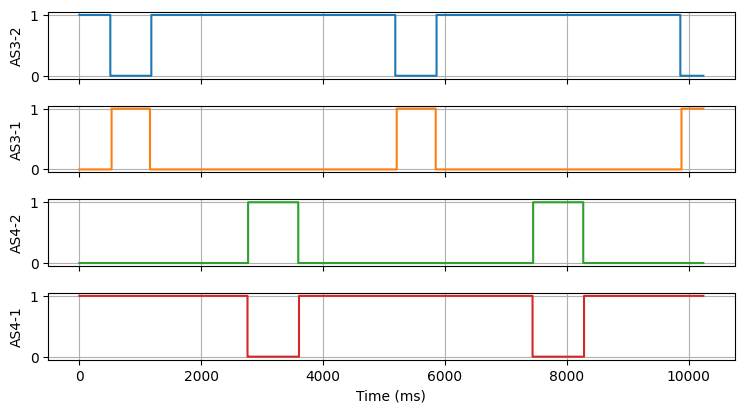

<IPython.core.display.Javascript object>

In [26]:
# Plot signals and pulses
grapher.plot_signals()

#### Plotting Signals with pulse width

The `SignalGrapher` class will draw pulse width according to `Configuration` **PLOT_WIDTH** value. The possible values are **"all"** (display all signals with width drawing), **"rising"** (display only for rising signals), **"falling"** (display only for falling signals), or **None** (no width drawing).

In [27]:
cfg.PLOT_WIDTH = "all"

<IPython.core.display.Javascript object>

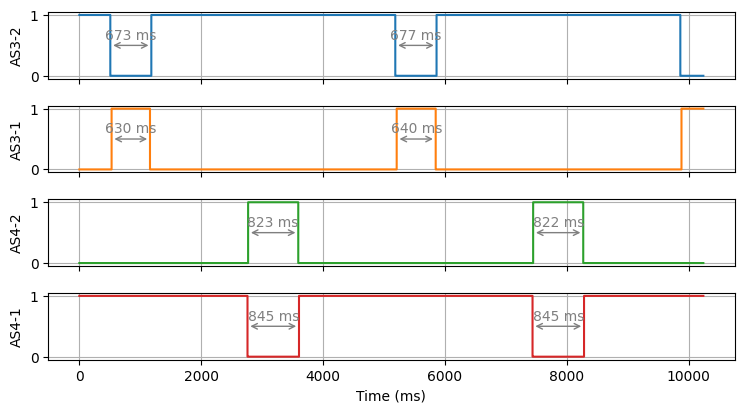

<IPython.core.display.Javascript object>

In [28]:
# Reinstantiate the SignalGrapher
grapher = SignalGrapher(
    processor.filtered_signals_df,
    processor.pulse_count,
    processor.pulse_points_width,
    processor.rising_signals,
)

# Plot signals and pulses
grapher.plot_signals()

In [29]:
cfg.PLOT_WIDTH = "rising"

<IPython.core.display.Javascript object>

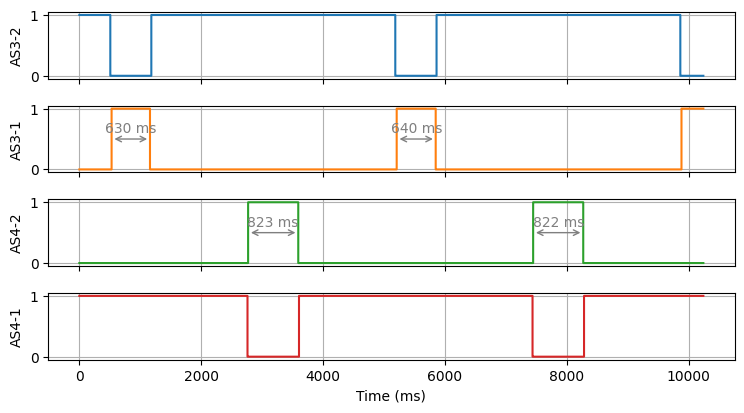

<IPython.core.display.Javascript object>

In [30]:
# Reinstantiate the SignalGrapher
grapher = SignalGrapher(
    processor.filtered_signals_df,
    processor.pulse_count,
    processor.pulse_points_width,
    processor.rising_signals,
)

# Plot signals and pulses
grapher.plot_signals()

In [31]:
cfg.PLOT_WIDTH = "falling"

<IPython.core.display.Javascript object>

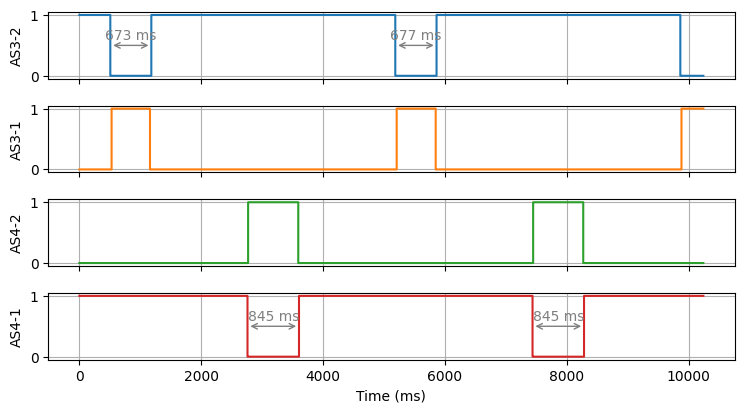

<IPython.core.display.Javascript object>

In [32]:
# Reinstantiate the SignalGrapher
grapher = SignalGrapher(
    processor.filtered_signals_df,
    processor.pulse_count,
    processor.pulse_points_width,
    processor.rising_signals,
)

# Plot signals and pulses
grapher.plot_signals()

#### Adding Vertical Lines

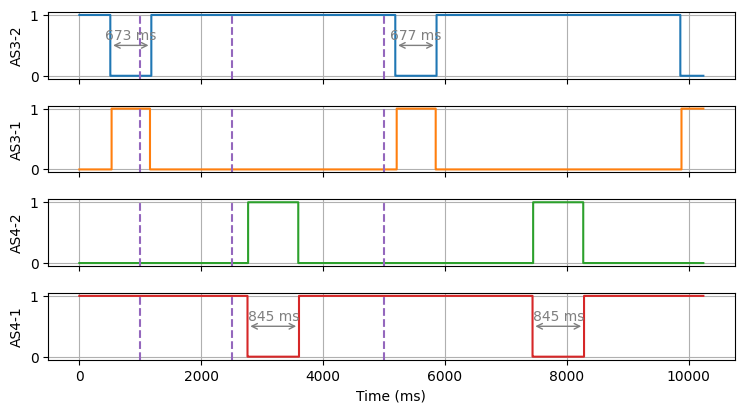

<IPython.core.display.Javascript object>

In [33]:
# Define list of x-coordinates for vertical lines
vlines = [1000, 2500, 5000]

# Add vertical dashed lines to the plot
grapher.add_vlines(vlines)

# Re-plot signals with added vertical lines
grapher.plot_signals()

## Class StorageController - Checking for USB flash storage and file name

The `StorageController` class is part of the analyzer_reporter project and is responsible for controlling USB storage operations. It provides functionality to check if a USB drive is plugged in, retrieve information about the USB drive, manage directories and files on the drive, and monitor the storage status.

In [34]:
# Uncomment and run the shell command below if you need the full contents of the module file.
# !cat storage_controller.py

<IPython.core.display.Javascript object>

In [35]:
import os

from config import Configuration as cfg
from logger import get_cls_logger


class StorageController:
    """Class to control USB storage"""

    logger = get_cls_logger(__qualname__)

    def __init__(self):
        self.logger.debug("Initialized %s", self.__class__.__name__)
        self.usb_plugged = self.check_usb_plugged()
        self.usb_mounted = False
        self.mount_point = None
        self.data_dir = None
        self.pdf_files = []
        self.last_pdf_report = None
        self.last_pdf_report_date = None
        self.last_pdf_report_idx = 0
        self.current_pdf_report = None
        self.current_pdf_report_idx = 0
        self.free_space = 0
        self.ready_to_write = False
        self.update()

    def update(self) -> None:
        """Update instance variables."""
        self.reset()

        if self.usb_plugged:
            self.get_mount_point()

            if self.usb_mounted:
                self._create_data_directory()
                self.get_pdf_files()
                self.get_last_pdf_report()
                self.get_last_pdf_report_date()
                self.get_last_pdf_report_idx()
                self._set_current_pdf_report()
                self.get_free_space()

                if self.free_space > cfg.WRITE_TRESHOLD:
                    self.ready_to_write = True

    def reset(self) -> None:
        """Reset instance variables."""
        self.usb_plugged = self.check_usb_plugged()
        self.usb_mounted = False
        self.mount_point = None
        self.data_dir = None
        self.pdf_files = []
        self.last_pdf_report = None
        self.last_pdf_report_date = None
        self.last_pdf_report_idx = 0
        self.current_pdf_report = None
        self.current_pdf_report_idx = 0
        self.free_space = 0
        self.ready_to_write = False

    def get_mount_point(self) -> None:
        """Get the mount point of the USB drive."""
        with open("/proc/mounts", "r", encoding="utf-8") as mounts:
            for line in mounts:
                if cfg.USB_DRIVE in line:
                    self.usb_mounted = True
                    self.mount_point = line.split()[1]
                    break

    def _create_data_directory(self) -> None:
        """Get or create data directory if it doesn't exist."""
        self.data_dir = os.path.join(self.mount_point, cfg.DATA_DIR_NAME)
        if not os.path.exists(self.data_dir):
            os.mkdir(self.data_dir)

    def get_pdf_files(self) -> None:
        """Get a list of PDF files in the data directory."""
        self.pdf_files = [
            f for f in os.listdir(self.data_dir) if f.lower().endswith(".pdf")
        ]

    def get_last_pdf_report(self) -> None:
        """Get the last PDF report file."""
        if self.pdf_files:
            self.last_pdf_report = sorted(self.pdf_files)[-1]

    def get_last_pdf_report_date(self) -> None:
        """Extract the date from the last PDF report file."""
        if self.last_pdf_report:
            self.last_pdf_report_date = "-".join(self.last_pdf_report.split("-")[:3])

    def get_last_pdf_report_idx(self) -> None:
        """Extract the index from the last PDF report file."""
        if self.last_pdf_report:
            self.last_pdf_report_idx = int(
                self.last_pdf_report.split("-")[3].split(".")[0]
            )

    def _set_current_pdf_report(self) -> None:
        """Set the current PDF report file index and full path."""
        self.current_pdf_report_idx = (
            1
            if cfg.CURRENT_DATE != self.last_pdf_report_date
            else self.last_pdf_report_idx + 1
        )
        self.current_pdf_report = os.path.join(
            self.data_dir,
            cfg.REPORT_NAME.format(IDX=str(self.current_pdf_report_idx).zfill(3)),
        )

    def get_free_space(self) -> None:
        """Get the free space in the USB drive."""
        statvfs: os.statvfs = os.statvfs(self.mount_point)
        self.free_space = statvfs.f_frsize * statvfs.f_bavail

    @staticmethod
    def check_usb_plugged() -> bool:
        """Check if USB is plugged in."""
        return os.path.exists(cfg.USB_DRIVE)

    @property
    def changed(self) -> bool:
        """Check for USB storage status."""
        previous_usb_plugged = self.usb_plugged
        previous_usb_mounted = self.usb_mounted
        previous_ready_to_write = self.ready_to_write

        self.update()

        return (
            previous_usb_plugged != self.usb_plugged
            or previous_usb_mounted != self.usb_mounted
            or previous_ready_to_write != self.ready_to_write
        )

<IPython.core.display.Javascript object>

### Usage Examples

#### Initializing the StorageController

In [36]:
from storage_controller import StorageController

# Initialize the StorageController
usb_storage = StorageController()

<IPython.core.display.Javascript object>

#### Checking if USB is Plugged In

In [37]:
# Check if USB drive is plugged in
usb_plugged = usb_storage.check_usb_plugged()
print("USB plugged in:", usb_plugged)

USB plugged in: False


<IPython.core.display.Javascript object>

#### Checking for Changed USB Storage Status

In [40]:
# Check if USB storage status has changed
status_changed = usb_storage.changed
print("USB storage status changed:", status_changed)

USB storage status changed: True


<IPython.core.display.Javascript object>

#### Retrieving various properties

In [41]:
print("USB Plugged:", usb_storage.usb_plugged)

# Check if USB drive is mounted
print("\nUSB Mounted:", usb_storage.usb_mounted)

# Get the mount point of the USB drive
print("\nMount Point:", usb_storage.mount_point)
print("\nData Directory:", usb_storage.data_dir)
print("\nPDF Files:", usb_storage.pdf_files)

# Get information about the last PDF report
print("\nLast PDF Report:", usb_storage.last_pdf_report)
print("\nLast PDF Report date:", usb_storage.last_pdf_report_date)
print("\nLast PDF Report index:", usb_storage.last_pdf_report_idx)
print("\nCurrent PDF Report:", usb_storage.current_pdf_report)

# Get the free space on the USB drive
print("\nFree Space:", usb_storage.free_space)
print("\nReady to Write:", usb_storage.ready_to_write)

USB Plugged: True

USB Mounted: True

Mount Point: /run/media/edyatl/usbstick

Data Directory: /run/media/edyatl/usbstick/data

PDF Files: ['2024-03-06-001.pdf', '2024-03-06-002.pdf', '2024-03-06-003.pdf', '2024-03-05-001.pdf', '2024-03-07-001.pdf', '2024-03-15-001.pdf', '2024-03-15-002.pdf', '2024-03-15-003.pdf', '2024-03-15-004.pdf', '2024-03-15-005.pdf', '2024-03-15-006.pdf', '2024-03-15-007.pdf', '2024-03-15-008.pdf', '2024-03-20-001.pdf', '2024-03-20-002.pdf', '2024-03-21-001.pdf', '2024-03-20-003.pdf', '2024-03-20-004.pdf', '2024-03-21-002.pdf', '2024-03-21-003.pdf', '2024-03-21-004.pdf', '2024-03-21-005.pdf', '2024-03-21-006.pdf', '2024-03-21-007.pdf', '2024-03-21-008.pdf', '2024-03-21-009.pdf', '2024-03-21-010.pdf', '2024-03-21-011.pdf', '2024-03-21-012.pdf', '2024-03-21-013.pdf', '2024-03-21-014.pdf', '2024-03-21-015.pdf', '2024-03-25-001.pdf', '2024-03-25-002.pdf', '2024-03-25-003.pdf', '2024-03-25-004.pdf', '2024-03-25-005.pdf', '2024-03-25-006.pdf', '2024-03-25-007.pdf', '2

<IPython.core.display.Javascript object>

## Class ReportGenerator - Saving PDF file with plots to USB flash drive

The `ReportGenerator` class is part of the analyzer_reporter project and is responsible for generating PDF reports. It allows users to create reports containing figures, text, and additional pulse width data in CSV format. This class utilizes the `matplotlib`, `reportlab`, and `pandas` libraries to create and manipulate PDF documents.

In [42]:
# Uncomment and run the shell command below if you need the full contents of the module file.
# !cat report_generator.py

<IPython.core.display.Javascript object>

In [43]:
import io

import numpy as np
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import figure as pltfg
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

from pypdf import PdfReader, PdfWriter

from config import Configuration as cfg
from logger import get_cls_logger


class ReportGenerator:
    """Class to generate PDF report."""

    logger = get_cls_logger(__qualname__)

    def __init__(
        self,
        figure: pltfg.Figure,
        report_file: str,
        attempt_number: int,
        capture_date: str,
    ):
        """Initialize ReportGenerator."""
        self.figure = figure
        self.report_file = report_file
        self.attempt_number = str(attempt_number).zfill(3)
        self.capture_date = capture_date
        self.template = self._load_template()

        self.add_text(self.attempt_number, cfg.ATTEMPT_POINT)
        self.add_text(self.capture_date, cfg.DATE_POINT)

        self.logger.debug("Initialized %s", self.__class__.__name__)

    def _load_template(self) -> io.BytesIO:
        """Load PDF template."""
        template = io.BytesIO()
        try:
            with open(cfg.TEMPLATE_FILE, "rb") as f:
                template.write(f.read())
            self.logger.debug("Template loaded from %s", cfg.TEMPLATE_FILE)
        except FileNotFoundError:
            c = canvas.Canvas(template, pagesize=A4)
            c.showPage()
            c.save()
            self.logger.warning(
                "Template file %s not found, using blank A4 canvas", cfg.TEMPLATE_FILE
            )
        template.seek(0)
        return template

    def add_text(self, text: str, point: tuple) -> None:
        """Add text to the template."""
        text_pdf = self._create_text_pdf(text, point)
        text_page = PdfReader(text_pdf).pages[0]

        pdf_reader = PdfReader(self.template)
        template_page = pdf_reader.pages[0]

        template_page.merge_page(page2=text_page)

        writer = PdfWriter()
        writer.append_pages_from_reader(pdf_reader)
        writer.write(self.template)

    def _create_text_pdf(self, text: str, point: tuple) -> io.BytesIO:
        """Create PDF with text."""
        text_pdf = io.BytesIO()
        c = canvas.Canvas(text_pdf, pagesize=A4)
        c.drawString(point[0], point[1], text)
        c.save()
        text_pdf.seek(0)
        return text_pdf

    def generate_report(self) -> None:
        """Generate PDF report."""
        figure_pdf = self._save_figure_to_pdf()
        figure_page = PdfReader(figure_pdf).pages[0]

        pdf_reader = PdfReader(self.template)
        template_page = pdf_reader.pages[0]

        template_page.merge_page(page2=figure_page)

        writer = PdfWriter()
        writer.append_pages_from_reader(pdf_reader)

        with open(self.report_file, "wb") as fp:
            writer.write(fp)

    def _save_figure_to_pdf(self) -> io.BytesIO:
        """Save figure to PDF."""
        figure_pdf = io.BytesIO()
        with PdfPages(figure_pdf) as pdf:
            pdf.savefig(self.figure)
        figure_pdf.seek(0)
        return figure_pdf

    def save_pulse_width_csv(self, pulse_width: dict) -> None:
        """Save pulse width data to CSV."""
        csv_file = self.report_file.replace(".pdf", "-pulse-width.csv")

        # Check if all lists in the dictionary have the same size
        max_size = max(len(val) for val in pulse_width.values())

        for key, val in pulse_width.items():
            if len(val) < max_size:
                # Pad shorter lists with NaNs
                val.extend([np.nan] * (max_size - len(val)))
            pulse_width[key] = val
        pd.DataFrame(pulse_width).to_csv(csv_file)

<IPython.core.display.Javascript object>

### Usage Examples

#### Initializing the ReportGenerator

In [44]:
from report_generator import ReportGenerator

# Assuming figure is a matplotlib figure object
# Assuming report_file is the path where the generated report will be saved
# Assuming attempt_number and capture_date are integers and strings respectively
# Initialize the ReportGenerator
generator = ReportGenerator(
    figure=grapher.figure,
    report_file=usb_storage.current_pdf_report,
    attempt_number=usb_storage.current_pdf_report_idx,
    capture_date=cfg.CURRENT_DATE,
)

<IPython.core.display.Javascript object>

#### Adding Text to the Report

In [45]:
# Assuming text is a string to be added to the report
text = "New Title"

# Assuming point is a tuple containing the (x, y) coordinates where the text will be placed
point = (450, 650)

# Add text to the report
generator.add_text(text, point)

<IPython.core.display.Javascript object>

#### Generating the Report

In [46]:
# Generate the PDF report
generator.generate_report()

<IPython.core.display.Javascript object>

#### Saving Pulse Width Data to CSV

In [47]:
# Assuming processor.pulse_width is a dictionary containing pulse width data
# Save pulse width data to a CSV file
generator.save_pulse_width_csv(processor.pulse_width)

<IPython.core.display.Javascript object>

## Core Module - Bringing Together Components for Comprehensive Functionality

The main module of the analyzer_reporter project orchestrates the entire process of capturing, processing, analyzing, and generating reports for signals from a logic analyzer. It utilizes various components such as storage controller, analyzer controller, signal processor, signal grapher, and report generator to achieve its functionality.

### Logic Flow

1. **Initialization**:
   - Initializes the LED and Button objects.
   - Sets up logging.

2. **Signal Handling**:
   - Configures a SIGTERM handler for graceful termination.

3. **Main Function**:
   - Creates a StorageController instance to manage USB storage.
   - Waits for USB storage to become ready for writing.
   - Turns on the LED to indicate readiness.
   - Waits for a button press within a specified timeout.
   - Captures signals using the AnalyzerController.
   - Processes the captured data using the SignalProcessor.
   - Generates a signal plot using the SignalGrapher.
   - Creates a PDF report using the ReportGenerator.
   - Saves pulse width data to a CSV file.

4. **Signal Handling (Continued)**:
   - Loops indefinitely, executing the main function repeatedly.
   - Handles SIGTERM signal for graceful termination.
   - Exits gracefully on KeyboardInterrupt.

In [48]:
# Uncomment and run the shell command below if you need the full contents of the module file.
# !cat analyzer_reporter.py

<IPython.core.display.Javascript object>

In [49]:
# Importing the Device class from gpiozero module
# Device class is used for configuring pin factories and other GPIO device settings
from gpiozero import Device

# Importing the MockFactory class from gpiozero.pins.mock module
# MockFactory class is used for creating mock pin factories for testing purposes
from gpiozero.pins.mock import MockFactory

# Setting the pin factory of the Device class to MockFactory
# This configuration allows GPIO pin operations to use a mock pin factory for testing
Device.pin_factory = MockFactory()

# Assigning a value of 15 to the BUTTON_TIMEOUT property in the cfg module
# This configuration sets the timeout value for button press detection to 15 seconds
cfg.BUTTON_TIMEOUT = 15

cfg.DEBUG = True

<IPython.core.display.Javascript object>

In [50]:
import sys
import time
import signal
from gpiozero import LED, Button

from config import Configuration as cfg
from logger import get_cls_logger
from storage_controller import StorageController
from analyzer_controller import AnalyzerController
from signal_processor import SignalProcessor
from signal_grapher import SignalGrapher
from report_generator import ReportGenerator

# Initialize LED and Button objects
led = LED(cfg.LED_PIN)
button = Button(cfg.BUTTON_PIN)

# Logger initialization
logger = get_cls_logger(__name__)
logger.info("Starting Analyzer and Reporter")


def sigterm_handler(sig, frame):
    """
    SIGTERM handler for graceful termination
    """
    logger.info("Received SIGTERM. Exiting...")
    led.off()
    sys.exit(0)


def log_usb_storage_info(usb_storage: StorageController) -> None:
    """
    Log information about USB storage.
    """
    usb_storage.logger.debug("USB Plugged: %s", usb_storage.usb_plugged)
    usb_storage.logger.debug("USB Mounted: %s", usb_storage.usb_mounted)
    usb_storage.logger.debug("Mount Point: %s", usb_storage.mount_point)
    usb_storage.logger.debug("Data Directory: %s", usb_storage.data_dir)
    usb_storage.logger.debug("PDF Files: %s", usb_storage.pdf_files)
    usb_storage.logger.debug("Last PDF Report: %s", usb_storage.last_pdf_report)
    usb_storage.logger.debug(
        "Last PDF Report date: %s", usb_storage.last_pdf_report_date
    )
    usb_storage.logger.debug(
        "Last PDF Report index: %s", usb_storage.last_pdf_report_idx
    )
    usb_storage.logger.debug("Current PDF Report: %s", usb_storage.current_pdf_report)
    usb_storage.logger.debug("Free Space: %s", usb_storage.free_space)
    usb_storage.logger.debug("Ready to Write: %s", usb_storage.ready_to_write)


def print_usb_storage_info(usb_storage: StorageController) -> None:
    """
    Print information about USB storage.
    """
    print("USB Plugged:", usb_storage.usb_plugged)
    print("USB Mounted:", usb_storage.usb_mounted)
    print("Mount Point:", usb_storage.mount_point)
    print("Data Directory:", usb_storage.data_dir)
    print("PDF Files:", usb_storage.pdf_files)
    print("Last PDF Report:", usb_storage.last_pdf_report)
    print("Last PDF Report date:", usb_storage.last_pdf_report_date)
    print("Last PDF Report index:", usb_storage.last_pdf_report_idx)
    print("Current PDF Report:", usb_storage.current_pdf_report)
    print("Free Space:", usb_storage.free_space)
    print("Ready to Write:", usb_storage.ready_to_write)
    print("---------------------------------\n")


def log_analyzer_controller_info(analyzer_controller: AnalyzerController) -> None:
    """
    Log information about analyzer controller.
    """
    analyzer_controller.logger.debug(
        "Real Capture: %s", analyzer_controller.real_capture
    )
    analyzer_controller.logger.debug("Data Path: %s", analyzer_controller.data_path)


def wait_for_usb_storage_ready(usb_storage: StorageController) -> None:
    """
    Wait until USB storage is ready to write.
    """
    led.blink(on_time=cfg.BLINK_TIME, off_time=cfg.BLINK_TIME)
    log_usb_storage_info(usb_storage)
    if cfg.DEBUG:
        print_usb_storage_info(usb_storage)
    while not usb_storage.ready_to_write:
        if usb_storage.changed and not usb_storage.ready_to_write:
            log_usb_storage_info(usb_storage)
            if cfg.DEBUG:
                print_usb_storage_info(usb_storage)
        time.sleep(0.5)


def main() -> None:
    """
    Main function
    """
    usb_storage = StorageController()

    if not usb_storage.ready_to_write:
        wait_for_usb_storage_ready(usb_storage)

    led.on()  # Turn LED on because relay has vice versa logic
    log_usb_storage_info(usb_storage)
    if cfg.DEBUG:
        print_usb_storage_info(usb_storage)

    button.wait_for_press(cfg.BUTTON_TIMEOUT)
    logger.debug("Button pressed!")
    led.blink(on_time=cfg.BLINK_TIME, off_time=cfg.BLINK_TIME)

    analyzer = AnalyzerController()
    df = analyzer.capture_signals()
    log_analyzer_controller_info(analyzer)

    if not df.empty:
        processor = SignalProcessor(df)
        processor.logger.debug(
            "Data processed and loaded to DataFrame: %s rows", df.shape[0]
        )

        grapher = SignalGrapher(
            filtered_signals_df=processor.filtered_signals_df,
            pulse_counts=processor.pulse_count,
            pulse_points_width=processor.pulse_points_width,
            rising_signals=processor.rising_signals,
        )
        grapher.plot_signals()
        grapher.logger.debug("Signals and pulses plotted")

        generator = ReportGenerator(
            figure=grapher.figure,
            report_file=usb_storage.current_pdf_report,
            attempt_number=usb_storage.current_pdf_report_idx,
            capture_date=cfg.CURRENT_DATE,
        )

        if usb_storage.changed:
            wait_for_usb_storage_ready(usb_storage)

        if usb_storage.ready_to_write:
            generator.generate_report()
            generator.save_pulse_width_csv(processor.pulse_width)
            generator.logger.debug("Report file %s saved.", generator.report_file)

<IPython.core.display.Javascript object>

### Usage Example

USB Plugged: True
USB Mounted: True
Mount Point: /run/media/edyatl/usbstick
Data Directory: /run/media/edyatl/usbstick/data
PDF Files: ['2024-03-06-001.pdf', '2024-03-06-002.pdf', '2024-03-06-003.pdf', '2024-03-05-001.pdf', '2024-03-07-001.pdf', '2024-03-15-001.pdf', '2024-03-15-002.pdf', '2024-03-15-003.pdf', '2024-03-15-004.pdf', '2024-03-15-005.pdf', '2024-03-15-006.pdf', '2024-03-15-007.pdf', '2024-03-15-008.pdf', '2024-03-20-001.pdf', '2024-03-20-002.pdf', '2024-03-21-001.pdf', '2024-03-20-003.pdf', '2024-03-20-004.pdf', '2024-03-21-002.pdf', '2024-03-21-003.pdf', '2024-03-21-004.pdf', '2024-03-21-005.pdf', '2024-03-21-006.pdf', '2024-03-21-007.pdf', '2024-03-21-008.pdf', '2024-03-21-009.pdf', '2024-03-21-010.pdf', '2024-03-21-011.pdf', '2024-03-21-012.pdf', '2024-03-21-013.pdf', '2024-03-21-014.pdf', '2024-03-21-015.pdf', '2024-03-25-001.pdf', '2024-03-25-002.pdf', '2024-03-25-003.pdf', '2024-03-25-004.pdf', '2024-03-25-005.pdf', '2024-03-25-006.pdf', '2024-03-25-007.pdf', '2024-

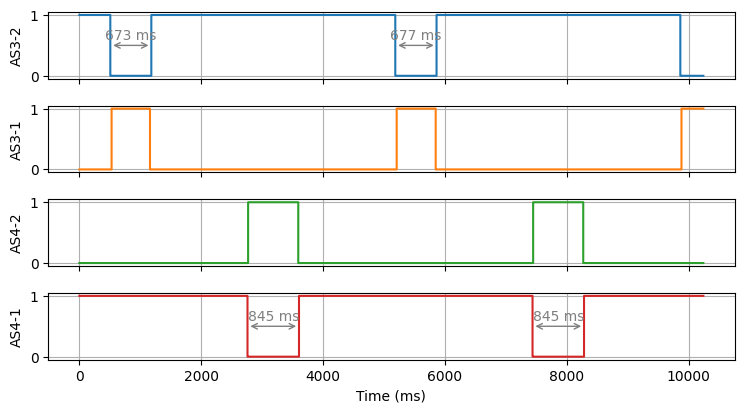

<IPython.core.display.Javascript object>

In [51]:
# Execute the main function once
main()

```python
# Execute the main function continuously
if __name__ == "__main__":
    signal.signal(signal.SIGTERM, sigterm_handler)
    try:
        while True:
            main()
    except KeyboardInterrupt:
        print("Received KeyboardInterrupt. Exiting...")
        led.off()
        sys.exit(0)
```

>**Notes:**
>    - The main module controls the entire workflow of the application, from signal capture to report generation.
>    - It ensures proper handling of USB storage, signal processing, and report generation, providing a comprehensive solution for analyzing logic signals.
>    - The module is designed to run indefinitely, continuously processing signals and generating reports until terminated.